# Competition Datasets
This notebooks aims to show how to download and import the required datasets for the competition using LIPS framework and set of features. 

### Prerequisites
Install the LIPS framework if it is not already done. For more information concerning the framework installation, look at the LIPS framework [Github Repository](https://github.com/IRT-SystemX/LIPS). You may start by creating a new python environment in order to avoid any package conflcits. Next, you can install the LIPS framework and its required dependencies using the following command.

In [ ]:
# !pip install -U .[recommended]
## or using the requirements file
# !pip install -r requirements.txt

### Import the dataset

In [1]:
### Import required packages
import os
from lips.benchmark.powergridBenchmark import PowerGridBenchmark

Define the required paths

In [3]:
BENCH_CONFIG_PATH = os.path.join("configs", "benchmarks", "lips_idf_2023.ini")
DATA_PATH = os.path.join("input_data_local", "lips_idf_2023")
LOG_PATH = "lips_log.log"

Download the dataset

In [ ]:
## Download the dataset through the dedicated lips function
from lips.dataset.powergridDataSet import downloadPowergridDataset

downloadPowergridDataset("input_data_local", "lips_idf_2023")

To load the dataset which are downloaded in the previous step, the LIPS framework could be used. The `PowerGridBenchmark` class is required for importing the dataset. The set of arguments that should be provided to instantiate this class are: 
- `benchmark_path`: A path to dataset
- `config_path`: A path to a specific configuration file (associated to each dataset) that should be used for the whole procedure of benchmarking and evaluation.
- `benchmark_name`: It corresponds to the directory that contains the data and also to a section of configuration file that includes the set of appropriate parameters for benchmarking.
- `load_data_set`: whether to load the downloaded dataset (the case of this competition) or create empty dataset objects (`False`) used for data generation (not used in the competition).
- `load_ybus_as_sparse`: The admittance matrix for `l2rpn_idf_2023` is a 3D matrix with dimensions `300000x236x236` for training set, and it is not possible to load it in memory as a dense matrix. This matrix for this environment is saved as `Scipy.sparse` format and this parameter tells the data module to load the `YBus` matrix in appropriate sparse format for this specific environment.
- `log_path`: The path where LIPS framework logs are saved for debugging purpose.

In [6]:
benchmark = PowerGridBenchmark(benchmark_path=DATA_PATH,
                               config_path=BENCH_CONFIG_PATH,
                               benchmark_name="Benchmark_competition",
                               load_data_set=True, # to load already generated dataset
                               load_ybus_as_sparse=True, # Ybus is registered as sparse
                               log_path=LOG_PATH)

Once the benchmark specific datasets are loaded, you can access them using the `benchmark` object, as shown below. There are four different datasets considered in this challenge:
- `train_dataset`: the largest dataset on which the proposed models (aka augmented simulators) should be trained and fitted.
- `val_dataset`: the validation set, that could be used optionally by participants for fine tuning of their models and to analyze the convergence behavior.
- `_test_dataset`: the test dataset has the same distribution of the training dataset and is used only for the evaluation of the trained model.
- `_test_ood_topo_dataset`: the out-of-distribution dataset which present a topologically different distribution than the training set and used to evaluate the generalization capability of the proposed models.

We can access the size of these datasets as follows:

In [7]:
print(benchmark.train_dataset.size)
print(benchmark.val_dataset.size)
print(benchmark._test_dataset.size)
print(benchmark._test_ood_topo_dataset.size)

300000
100000
100000
200000


The data in each provided dataset is organized as a dictionary (key, item) and could be accessed using the `data` attribute of the dataset isntance as follows:

In [5]:
benchmark.train_dataset.data.keys()

dict_keys(['prod_p', 'prod_v', 'load_p', 'load_q', 'line_status', 'topo_vect', 'a_or', 'a_ex', 'p_or', 'p_ex', 'v_or', 'v_ex', 'theta_or', 'theta_ex', 'YBus', 'SBus', 'PV_nodes', 'slack'])

There are four categories of data types that some of them could be used optionally by the users. Among all the variables, those highlighted in <span style="color:green"><b>green</b></span> are mendatory as inputs and outputs and those highlighted in <span style="color:orange"><b>orange</b></span> are optional and aimed to be used for Physics Informed Neural Networks (PINNs) based approaches.

- **Main input variables**

    - `attr_x`: the injections at each substation which should be used as input variables. They correspond to production active power <span style="color:green"><b>prod_p</b></span> and voltage <span style="color:green"><b>prod_v</b></span>, and load active <span style="color:green"><b>load_p</b></span> and reactive <span style="color:green"><b>load_q</b></span> powers.

    - `attr_tau`: Corresponds to power grid topology attributes:
        - <span style="color:green"><b>line_status</b></span>: A boolean indicating the status of each power line at each state of the environment (observation). If a line is connected, its corresponding status is `True`, otherwise it is `False`.
        - <span style="color:green"><b>topo_vect</b></span>: A discrete variable indicating via which bus bar the elements of the network are connected. It could take three values (`1` if an element (power line, production, load and storage) is connected via bus bar 1, `2` if an element is connected via bus bar 2 and `-1` if the element is disconnected.)

- **Output variables**

    - `attr_y`: It corresponds to the power flows that should be predicted. It includes the complete set of targets. In this competition, we require the predictions of 
        - Currents at the origin (<span style="color:green"><b>a_or</b></span>) and the extremity (<span style="color:green"><b>a_ex</b></span>) of power lines; 
        - Active powers at the origin (<span style="color:green"><b>p_or</b></span>) and the extremity (<span style="color:green"><b>p_ex</b></span>) of power lines;
        - Voltages at the origin (<span style="color:green"><b>v_or</b></span>) and the extremity (<span style="color:green"><b>v_ex</b></span>) of power lines.
        - One also could use optionally the voltage angle values (<span style="color:orange"><b>theta_or</b></span>) and (<span style="color:orange"><b>theta_ex</b></span>) as the target from which the other quantities could be inferred. <span style="color:red">(More details on this will be provided soon in a separate notebook)</span>
        
- **Optional input variables**

    - `attr_physics`: Corresponds to physical attributes which could be used as the input information for approaches (e.g., physics informed neural network). It includes the following information: 
        - <span style="color:orange"><b>YBus</b></span>: which is the admittance matrix. This matrix include the admittance (complex value) between each pair of nodes (substations) in power grid.
        - <span style="color:orange"><b>Sbus</b></span>: the power (active and reactive) at each node of the power grid.
        - <span style="color:orange"><b>PV_nodes</b></span>: the nodes indices which retain the voltage.
        - <span style="color:orange"><b>slack</b></span>: The slack nodes information.

In [6]:
data_categories = ["attr_x", "attr_y", "attr_tau", "attr_physics"]
for category in data_categories:
    print(category, ": ", benchmark.config.get_option(category))

attr_x :  ('prod_p', 'prod_v', 'load_p', 'load_q')
attr_y :  ('a_or', 'a_ex', 'p_or', 'p_ex', 'v_or', 'v_ex', 'theta_or', 'theta_ex')
attr_tau :  ('line_status', 'topo_vect')
attr_physics :  ('YBus', 'SBus', 'PV_nodes', 'slack')


### Data visualization

The plotting utility of LIPS framework could be used to visualize the network topologies for each observation of each dataset. 

Here, we select the `_test_dataset` which includes some reference topology changes and one disconnected line per observation (grid state).

In [4]:
from lips.plot.power_grid import PlotData
obs_plotter = PlotData(dataset=benchmark._test_dataset, env_name=benchmark.env_name)

The different functions provided within `PlotData` class allows to walk through the observations of each dataset. we can observe a topology change at the substation 99 and a disconnection occured at the power line connecting nodes 18 and 19.

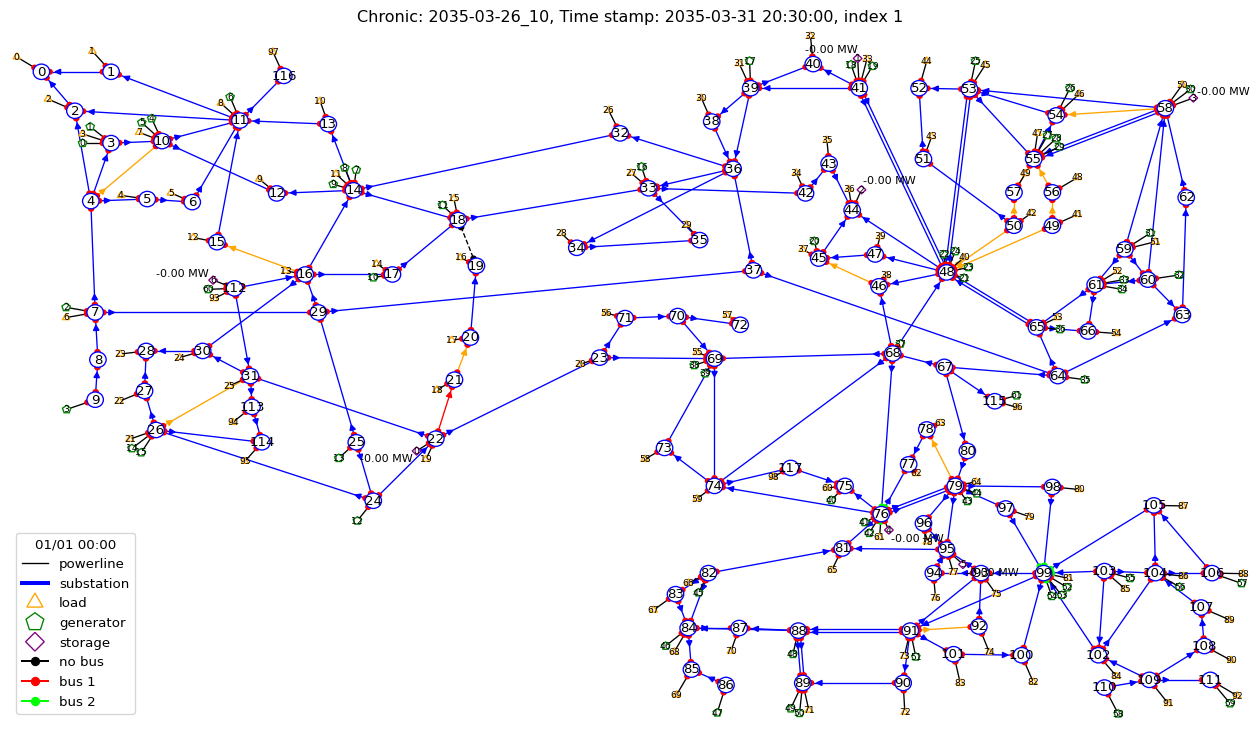

In [5]:
# visualize the next network topology of test dataset
obs_plotter.visualize_next()

Here, we select the `_test_ood_topo_dataset` which includes some reference topology changes and two disconnected power lines per observation (grid state).

In [9]:
from lips.plot.power_grid import PlotData
obs_plotter = PlotData(dataset=benchmark._test_ood_topo_dataset, env_name=benchmark.env_name)

we can observe a topology change at substations 48 and 68  and two disconnections occured at the power line connecting node 41 to 48 and node 33 to 42.

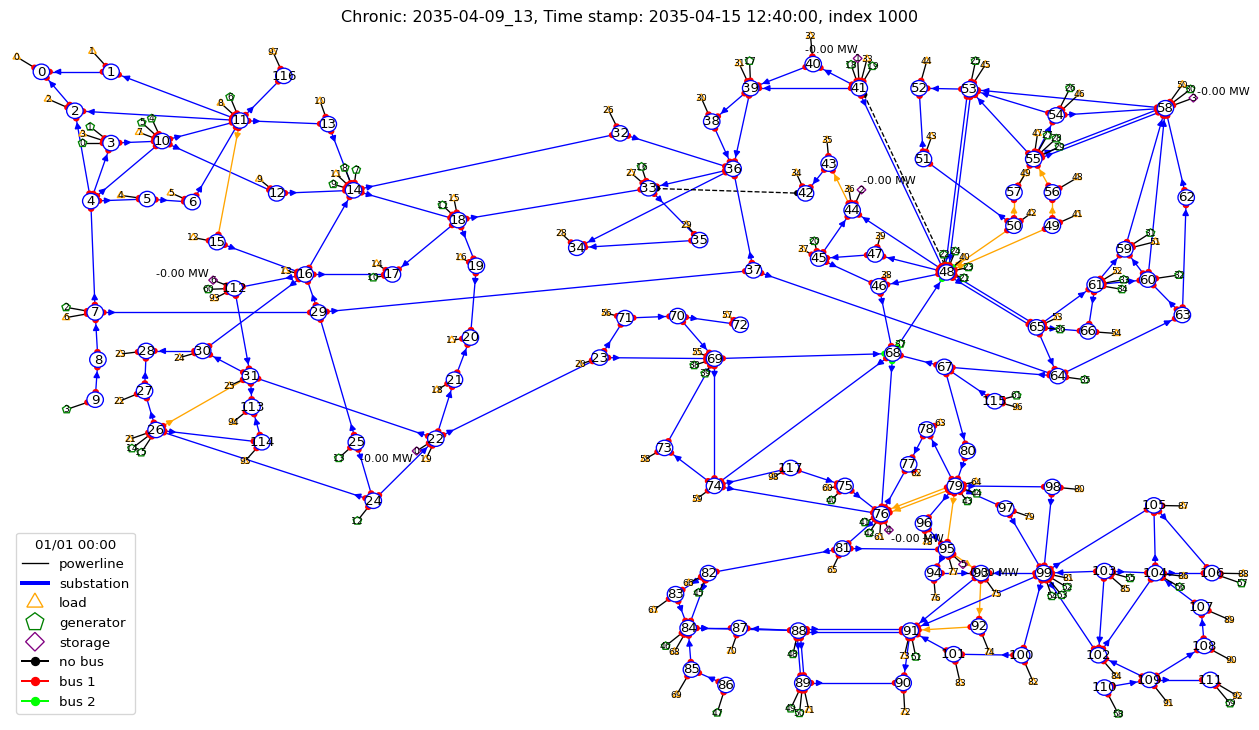

In [10]:
# visualize the next network topology of test dataset
obs_plotter.visualize_obs(id_obs=1000)

We can also select the information that we want to visualize on power lines, generators and loads via the provided arguments.

Here, we opt to show the active powers $P$ (MW) on the power lines, which is one of the variables that should be predicted by the models.

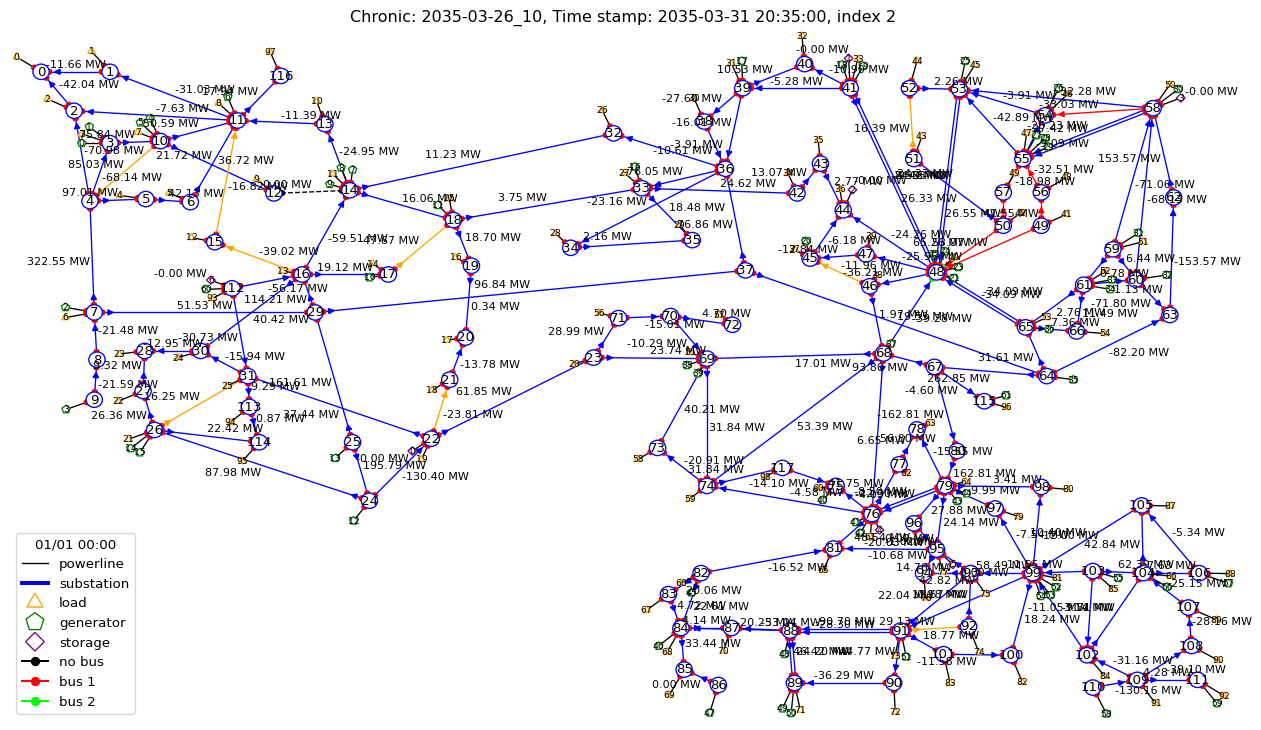

In [8]:
obs_plotter.visualize_next(line_info="p")

The current $A$ (Amper) is another variable that should be predicted and could be visualized as follows. Using the same argument and the value $v$, on could visualize the voltages on the power line.

In [10]:
obs_plotter.visualize_next(line_info="a")

### using plotly

The same functionalities are also provided using Plotly library for more interactive graphical representation of grid state.

In [5]:
from lips.plot.power_grid import PlotDataPlotly
obs_plotter = PlotDataPlotly(dataset=benchmark._test_dataset, env_name=benchmark.env_name)

In [6]:
obs_plotter.visualize_next()